In [1]:
import cv2
from matplotlib import pyplot
import numpy as np
from scipy.fftpack import dct
from scipy.fftpack import idct
import struct
import zlib

# Zadanie 1

In [2]:
#
# PPM file header
#
height = 500
width = 500

ppm_ascii_header = 'P3\n{} {}\n255\n'.format(width,height) 
ppm_binary_header =  'P6\n{} {}\n255\n'.format(width,height)

#
# Image data
#
image = np.zeros((height, width, 3), dtype=np.uint8)

#
# Save the PPM image as an ASCII file
#
with open('lab4-ascii.ppm', 'w') as fh:
    fh.write(ppm_ascii_header)
    image.tofile(fh, sep=' ')
    fh.write('\n')

#
# Save the PPM image as a binary file
#
with open('lab4-binary.ppm', 'wb') as fh:
    fh.write(bytearray(ppm_binary_header, 'ascii'))
    image.tofile(fh)
    fh.write(image.tobytes())


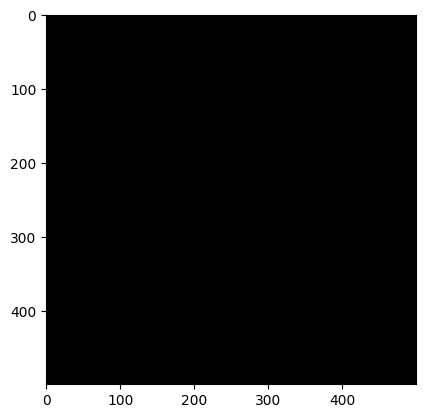

In [3]:
#
# Display image
#
image_from_file = cv2.imread('lab4-ascii.ppm')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

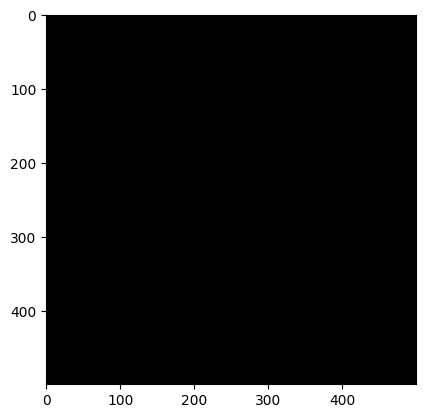

In [4]:
#
# Display image
#
image_from_file = cv2.imread('lab4-binary.ppm')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Zadanie 2

In [5]:
height = 100
width = 7*255

color_map = [(0, 0, 0),     # Black
             (0, 0, 255),   # Blue
             (0, 255, 255), # Cyan
             (0, 255, 0),   # Green
             (255, 255, 0), # Yellow
             (255, 0, 0),   # Red
             (255, 0, 255), # Purple
             (255, 255, 255)] # White

ppm_ascii_header = 'P3\n{} {}\n255\n'.format(width,height) 

image = np.zeros((height, width, 3), dtype=np.uint8)

def switch_case(case, x):
    switcher = {
        0: [0, 0, x],
        1: [0, x, 255],
        2: [0, 255, 255 - x],
        3: [x, 255, 0],
        4: [255, 255 - x, 0],
        5: [255, 0, x],
        6: [255, x, 255],
    }
    return switcher.get(case, 'Invalid case')

color_counter = 0
for i in range(width):
    image[:, i] = switch_case(color_counter//255, color_counter%255)
    color_counter+=1

with open('lab4-rainbow.ppm', 'w') as fh:
    fh.write(ppm_ascii_header)
    image.tofile(fh, sep=' ')
    fh.write('\n')


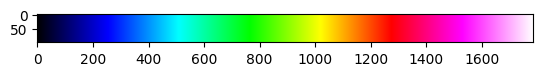

In [6]:
#
# Display image
#
image_from_file = cv2.imread('lab4-rainbow.ppm')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Zadanie 3

In [7]:

#
# Construct signature
#
png_file_signature = b'\x89\x50\x4E\x47\x0D\x0A\x1A\x0A'

#
# Construct header
#

bit_depth = 8
color_type = 2  # RGB
compression_method = 0
filter_method = 0
interlace_method = 0

header_id = b'IHDR'
header_content = (
    width.to_bytes(4, byteorder='big') +
    height.to_bytes(4, byteorder='big') +
    bit_depth.to_bytes(1, byteorder='big') +
    color_type.to_bytes(1, byteorder='big') +
    compression_method.to_bytes(1, byteorder='big') +
    filter_method.to_bytes(1, byteorder='big') +
    interlace_method.to_bytes(1, byteorder='big'))
    
    
header_size = len(header_content).to_bytes(4, byteorder='big')
header_crc = struct.pack('!I', zlib.crc32(header_id + header_content))

png_file_header = header_size + header_id + header_content + header_crc


#
# Construct data
#
data_id = b'IDAT'
data_content = zlib.compress(b''.join([b'\x00' + bytes(row) for row in image]))
data_size = len(data_content).to_bytes(4, byteorder='big')
data_crc = struct.pack('!I', zlib.crc32(data_id + data_content))
png_file_data = data_size + data_id + data_content + data_crc

#
# Consruct end
#
end_id = b'IEND'
end_content = b''
end_size = struct.pack('!I', len(end_content))
end_crc = struct.pack('!I', zlib.crc32(end_id + end_content))
png_file_end = end_size + end_id + end_content + end_crc

#
# Save the PNG image as a binary file
#
with open('lab4.png', 'wb') as fh:
    fh.write(png_file_signature)
    fh.write(png_file_header)
    fh.write(png_file_data)
    fh.write(png_file_end)

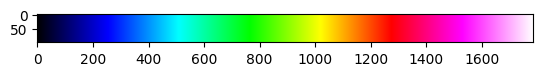

In [8]:
#
# Display image
#
image_from_file = cv2.imread('lab4.png')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Funkcje pomocnicze do zadań 4 i 5

In [9]:
#
# 2d Discrete Cosinus Transform
#
def dct2(array):
    return dct(dct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


def idct2(array):
    return idct(idct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


#
# Calculate quantisation matrices
#
# Based on: https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/jpegUpToQuant.html
#           #step-3-and-4-discrete-cosinus-transform-and-quantisation
#
_QY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                   [12, 12, 14, 19, 26, 48, 60, 55],
                   [14, 13, 16, 24, 40, 57, 69, 56],
                   [14, 17, 22, 29, 51, 87, 80, 62],
                   [18, 22, 37, 56, 68, 109, 103, 77],
                   [24, 35, 55, 64, 81, 104, 113, 92],
                   [49, 64, 78, 87, 103, 121, 120, 101],
                   [72, 92, 95, 98, 112, 100, 103, 99]])

_QC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                   [18, 21, 26, 66, 99, 99, 99, 99],
                   [24, 26, 56, 99, 99, 99, 99, 99],
                   [47, 66, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99]])


def _scale(QF):
    if QF < 50 and QF >= 1:
        scale = np.floor(5000 / QF)
    elif QF < 100:
        scale = 200 - 2 * QF
    else:
        raise ValueError('Quality Factor must be in the range [1..99]')

    scale = scale / 100.0
    return scale


def QY(QF=85):
    return _QY * _scale(QF)


def QC(QF=85):
    return _QC * _scale(QF)

# Zadania 4 i 5

In [10]:
#
# 0. Image data
#
# TODO: implement (zad. 4)

#
# 1. Convert RGB to YCbCr
new_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

#
# 2. Downsampling on Cb and Cr channels

new_image[1::2, :, 1] = new_image[:-1:2, :, 1]
new_image[:, 1::2, 2] = new_image[:, :-1:2, 2]
#
# 3. Produce 8x8 blocks
#
blocks = []
for i in range(0, new_image.shape[0], 8):
    for j in range(0, new_image.shape[1], 8):
        block = new_image[i:i+8, j:j+8]
        blocks.append(block)

#
# 4. Calculate DCT on each block
#
dct_blocks = []
for block in blocks:
    dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
    dct_blocks.append(dct_block)

#
# 5. Divide each block by quantisation matrix
#
quantized_blocks = []
for dct_block in dct_blocks:
    quantized_block = np.round(dct_block /_QC)
    quantized_blocks.append(quantized_block)
#
# 6. Round values in each block to integers
#
# TODO: implement (zad. 5)

#
# 7. Zig Zag
#
# TODO: implement (zad. 4)

#
# 8. Flatten, concatenate, compress and calculate the size -- how many bytes?
#
# TODO: implement (zad. 4)

#
# 7'. Undo Zig Zag
#
# We can skip it in this exercise! We did Zig Zag only for analysis in step 8.
# You can continue with result from step 6. instead of implementing undo here.
#

#
# 6'. Nothing to do here   ¯\_(ツ)_/¯
#
# No conversion is really needed here, just proceed to the next step.
#

#
# 5'. Reverse division by quantisation matrix -- multiply
#
# TODO: implement (zad. 5)

#
# 4'. Reverse DCT
#
# TODO: implement (zad. 5)

#
# 3'. Combine 8x8 blocks to original image
#
# TODO: implement (zad. 4)

#
# 2'. Upsampling on Cb and Cr channels
#
# TODO: implement (zad. 4)

#
# 1'. Convert YCbCr to RGB
#
# TODO: implement (zad. 4)

#
# 0'. Save the decoded image -- as PPM or PNG
#
# TODO: implement (zad. 4)

ValueError: operands could not be broadcast together with shapes (8,8,3) (8,8) 

In [ ]:
#
# Display image
#
image_from_file = cv2.imread('lab4-po-kompresji-i-dekompresji-jpeg.png')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Obserwacje z zadań 4 i 5